In [1]:
import numpy as np
import centpy.centpy
from centpy import *
# Setup up visualization
%matplotlib notebook
from matplotlib import rcParams
rcParams['figure.dpi']  = 60
import matplotlib.pyplot as plt
from matplotlib import animation

j0 = slice(2, -2)

We solve the equations of ideal magnetohydrodynamics in 1D 

\begin{equation} 
\partial_t 
\begin{bmatrix} 
\rho \\ \rho v_x \\ \rho v_y \\ \rho v_z \\ B_x \\ B_y \\ B_z \\ E 
\end{bmatrix} 
+ 
\partial_x 
\begin{bmatrix} 
\rho v_x \\ \rho v_x^2 + p^* - B_x^2 \\ \rho v_x v_y - B_x B_y \\
\rho v_x v_z - B_x B_z \\ 0 \\ B_y v_x - B_x v_y \\ B_z v_x - B_x v_z \\
(E+p^*) v_x - B_x (B_x v_x + B_y v_y + B_z v_Z) 
\end{bmatrix} 
+ 
\partial_y
\begin{bmatrix} 
\rho v_y \\ \rho v_y v_x - B_y B_x \\ \rho v_y^2 + p^* - B_y^2  \\
\rho v_y v_z - B_y B_z \\ B_x v_y - B_y v_x \\ 0 \\ B_z v_y - B_y v_z \\
(E+p^*) v_y - B_y (B_x v_x + B_y v_y + B_z v_Z) 
\end{bmatrix} 
= 0 
\end{equation}

where the total pressure is given by 

\begin{equation}
p^* = p + \frac{1}{2} (B_x^2 + B_y^2 + B_z^2)
\end{equation}

with the equation of state

\begin{equation}
p = (\gamma-1) \left(E-\frac{1}{2} \rho (v_x^2+v_y^2+v_z^2) - 
\frac{1}{2}(B_x^2 + B_y^2 + B_z^2)\right), \qquad \gamma=5/3
\end{equation}

The solution is computed on the domain $(x,y,t)\in([0,2\pi]\times[0,2\pi]\times[0,3])$ with initial data for an *Orszag-Tang vortex system*:

\begin{equation}
(\rho, v_x, v_y, v_z, B_x, B_y, B_z, p)_{t=0} = 
(\gamma^2, -\sin y, \sin x, 0, -\sin y, \sin (2x), 0, \gamma)
\end{equation}

and Dirichlet boundary data set by initial data on each boundary. The solution is computed using a 288$\times$288 mesh and CFL number 0.75.

In [3]:
pars = centpy.Pars2d(
    x_init=0.0,
    x_final=2.0 * np.pi,
    y_init=0.0,
    y_final=2.0 * np.pi,
    J=144,
    K=144,
    t_final=3.0,
    dt_out=0.05,
    cfl=0.75,
    scheme="sd2",
)
pars.gamma = 5.0 / 3

In [8]:
# MHD equation
class MHD2d(centpy.Equation2d):

    # Helper functions for the equation

    def pressure(self, u):
        return (self.gamma - 1.0) * (
            u[:, :, 7]
            - 0.5 * (u[:, :, 1] ** 2 + u[:, :, 2] ** 2 + u[:, :, 3] ** 2) / u[:, :, 0]
            - 0.5 * (u[:, :, 4] ** 2 + u[:, :, 5] ** 2 + u[:, :, 6] ** 2)
        )

    def pressure_star(self, u):
        return self.pressure(u) + 0.5 * (
            u[:, :, 4] ** 2 + u[:, :, 5] ** 2 + u[:, :, 6] ** 2
        )

    def initial_data(self):
        u = np.zeros((self.J + 4, self.K + 4, 8))
        x = self.xx.T
        y = self.yy.T
        gamma = self.gamma
        dx = self.dx
        dy = self.dy

        u[:, :, 0] = gamma ** 2
        u[:, :, 1] = u[:, :, 0] / dy * (np.cos(y + 0.5 * dy) - np.cos(y - 0.5 * dy))
        u[:, :, 2] = 0.0
        u[:, :, 3] = -u[:, :, 0] / dx * (np.cos(x + 0.5 * dx) - np.cos(x - 0.5 * dx))
        u[:, :, 4] = 1.0 / dy * (np.cos(y + 0.5 * dy) - np.cos(y - 0.5 * dy))
        u[:, :, 5] = 0.0
        u[:, :, 6] = ( -0.5 / dx * (np.cos(2.0 * (x + 0.5 * dx)) - np.cos(2.0 * (x - 0.5 * dx))) )

        I1 = ( -0.125/dy*(u[:, :, 0] + 1.0)*(np.sin(2.0 * (y + 0.5 * dy)) - np.sin(2.0 * (y - 0.5 * dy))) )
        I2 = ( -0.125/dx*u[:, :, 0]*(np.sin(2.0 * (x + 0.5 * dx)) - np.sin(2.0 * (x - 0.5 * dx))) )
        I3 = ( -0.0625 / dx * (np.sin(4.0 * (x + 0.5 * dx)) - np.sin(4.0 * (x - 0.5 * dx))) )
        u[:, :, 7] = 3.0 + 0.5 * u[:, :, 0] + I1 + I2 + I3

        return u

    def boundary_conditions(self, u):  # periodic
        # x-boundary
        u[0] = u[-4]
        u[1] = u[-3]
        u[-2] = u[2]
        u[-1] = u[3]
        # y-boundary
        u[:, 0] = u[:, -4]
        u[:, 1] = u[:, -3]
        u[:, -2] = u[:, 2]
        u[:, -1] = u[:, 3]

    def flux_x(self, u):
        f = np.empty_like(u)

        p_star = self.pressure_star(u)

        f[:, :, 0] = u[:, :, 1]
        f[:, :, 1] = u[:, :, 1] ** 2 / u[:, :, 0] + p_star - u[:, :, 4] ** 2
        f[:, :, 2] = u[:, :, 1] * u[:, :, 2] / u[:, :, 0] - u[:, :, 4] * u[:, :, 5]
        f[:, :, 3] = u[:, :, 1] * u[:, :, 3] / u[:, :, 0] - u[:, :, 4] * u[:, :, 6]
        f[:, :, 4] = 0.0
        f[:, :, 5] = (
            u[:, :, 1] * u[:, :, 5] / u[:, :, 0] - u[:, :, 4] * u[:, :, 2] / u[:, :, 0]
        )
        f[:, :, 6] = (
            u[:, :, 1] * u[:, :, 6] / u[:, :, 0] - u[:, :, 4] * u[:, :, 3] / u[:, :, 0]
        )
        f[:, :, 7] = (u[:, :, 7] + p_star) * u[:, :, 1] / u[:, :, 0] - u[:, :, 4] * (
            u[:, :, 4] * u[:, :, 1] / u[:, :, 0]
            + u[:, :, 5] * u[:, :, 2] / u[:, :, 0]
            + u[:, :, 6] * u[:, :, 3] / u[:, :, 0]
        )

        return f

    def flux_y(self, u):
        g = np.empty_like(u)

        p_star = self.pressure_star(u)

        g[:, :, 0] = u[:, :, 3]
        g[:, :, 1] = u[:, :, 3] * u[:, :, 1] / u[:, :, 0] - u[:, :, 4] * u[:, :, 6]
        g[:, :, 2] = u[:, :, 3] * u[:, :, 2] / u[:, :, 0] - u[:, :, 5] * u[:, :, 6]
        g[:, :, 3] = u[:, :, 3] ** 2 / u[:, :, 0] + p_star - u[:, :, 6] ** 2

        g[:, :, 4] = (
            u[:, :, 3] * u[:, :, 4] / u[:, :, 0] - u[:, :, 6] * u[:, :, 1] / u[:, :, 0]
        )
        g[:, :, 5] = (
            u[:, :, 3] * u[:, :, 5] / u[:, :, 0] - u[:, :, 6] * u[:, :, 2] / u[:, :, 0]
        )
        g[:, :, 6] = 0.0
        g[:, :, 7] = (u[:, :, 7] + p_star) * u[:, :, 3] / u[:, :, 0] - u[:, :, 6] * (
            u[:, :, 4] * u[:, :, 1] / u[:, :, 0]
            + u[:, :, 5] * u[:, :, 2] / u[:, :, 0]
            + u[:, :, 6] * u[:, :, 3] / u[:, :, 0]
        )

        return g

    def spectral_radius_x(self, u):
        rho = u[:, :, 0]
        vx = u[:, :, 1] / rho
        vy = u[:, :, 2] / rho
        vz = u[:, :, 3] / rho
        p = (self.gamma - 1.0) * (
            u[:, :, 7]
            - 0.5 * rho * (vx ** 2 + vy ** 2 + vz ** 2)
            - 0.5 * (u[:, :, 4] ** 2 + u[:, :, 5] ** 2 + u[:, :, 6] ** 2)
        )
        A = self.gamma * p / rho
        B = (u[:, :, 4] ** 2 + u[:, :, 5] ** 2 + u[:, :, 6] ** 2) / rho
        cfx = np.sqrt(
            0.5 * (A + B + np.sqrt((A + B) ** 2 - 4 * A * u[:, :, 4] ** 2 / rho))
        )
        # cfy = np.sqrt(
        #     0.5 * (A + B + np.sqrt((A + B) ** 2 - 4 * A * u[:, :, 6] ** 2 / rho))
        # )

        return np.abs(vx) + cfx

    def spectral_radius_y(self, u):
        rho = u[:, :, 0]
        vx = u[:, :, 1] / rho
        vy = u[:, :, 2] / rho
        vz = u[:, :, 3] / rho
        p = (self.gamma - 1.0) * (
            u[:, :, 7]
            - 0.5 * rho * (vx ** 2 + vy ** 2 + vz ** 2)
            - 0.5 * (u[:, :, 4] ** 2 + u[:, :, 5] ** 2 + u[:, :, 6] ** 2)
        )
        A = self.gamma * p / rho
        B = (u[:, :, 4] ** 2 + u[:, :, 5] ** 2 + u[:, :, 6] ** 2) / rho
        # cfx = np.sqrt(
        #     0.5 * (A + B + np.sqrt((A + B) ** 2 - 4 * A * u[:, :, 4] ** 2 / rho))
        # )
        cfy = np.sqrt(
            0.5 * (A + B + np.sqrt((A + B) ** 2 - 4 * A * u[:, :, 6] ** 2 / rho))
        )

        return np.abs(vy) + cfy

In [10]:
eqn = MHD2d(pars)
soln = centpy.Solver2d(eqn)
soln.solve()

<IPython.core.display.Javascript object>


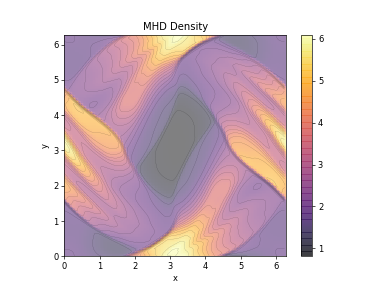

In [7]:
# Animation

x_init = soln.x_init
x_final = soln.x_final
y_init = soln.y_init
y_final = soln.y_final
x = soln.x
y = soln.y
u_n = soln.u_n
Nt = soln.Nt

fig = plt.figure()
ax = plt.axes(xlim=(x_init,x_final), ylim=(y_init, y_final))

ax.set_title("MHD Density")
ax.set_xlabel("x")
ax.set_ylabel("y")

#contours=ax.contour(x[j], y[j], u_n[0,j,j,0], 6, colors='black') 
img=ax.imshow(u_n[0,j0,j0,0], extent=[0, 6.3, 0, 6.3], origin='lower',
           cmap='inferno', alpha=0.5)
#cl=ax.clabel(contours, inline=True, fontsize=8)

fig.colorbar(img)
plt.axis(aspect='image')
def animate(i):
    ax.collections = []
    ax.contour(x[j0], y[j0], u_n[i,j0,j0,0], 20, colors='black',linewidths=0.1) 
    img.set_array(u_n[i,j0,j0,0])
    img.autoscale()
    
# call the animator.  blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, frames=Nt, interval=50, blit=False)
 
plt.show()